### Common imports

In [1]:
import ipywidgets as widgets 
import matplotlib.pyplot as plt
import numpy as np

%matplotlib notebook
from IPython.display import display

### Gaussian Policy

In [2]:
import sys
import os

sys.path.insert(0, "/home/giuseppe/catkin_ws/src/sampling_based_control/mppi/python")
import numpy as np
import matplotlib.pyplot as plt
import pymppi as pys
import time
    
n_inputs = 4

config = pys.Config()
config.horizon = 1.0
config.step_size = 0.01
config.samples = 10
config.filters_window = [10] * n_inputs
config.filters_order = [3] * n_inputs
config.variance = [0.01] * n_inputs
config.u_max = [1.0] * n_inputs
config.u_min = [-1.0] * n_inputs


policy = pys.GaussianPolicy(n_inputs, config)

### Utilities

In [3]:
# Utility
def get_samples_matrix(p):
    time = p.get_time()
    y_samples = [p.get_sample(time[0], k) for k in range(config.samples)]
    for t in time[1:]:
        for k in range(config.samples):
            y_samples[k] = np.vstack((y_samples[k], p.get_sample(t, k)))
    return y_samples

def get_nominal_matrix(p):
    time = p.get_time()
    y_nominal = p.get(time[0])
    for t in time[1:]:
        y_nominal = np.vstack((y_nominal, policy.get(t)))
    return y_nominal

### Plot policy

<IPython.core.display.Javascript object>


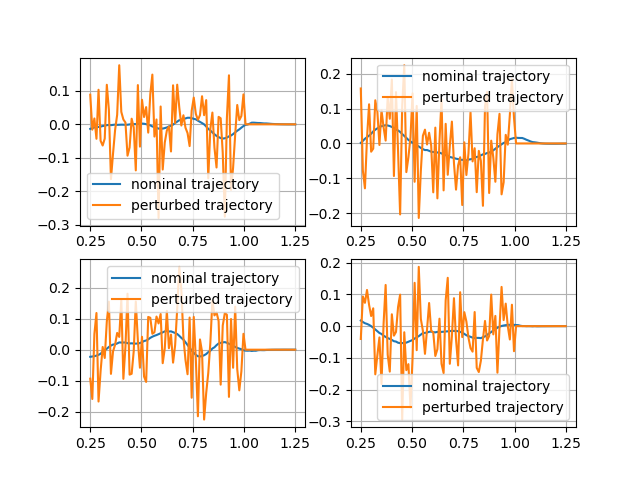

interactive(children=(IntSlider(value=4, description='s', max=9), Checkbox(value=False, description='show_all'…

In [4]:
weights = np.ones(config.samples)
keep = 3
policy.update_samples(weights, 0)
# weights = np.linspace(n_samples, 1, n_samples)
# weights = weights / np.sum(weights)
weights = np.zeros(config.samples)
weights[0] = 1.0

time = policy.get_time()
sample = 0
only_nom = False

y_nominal = get_nominal_matrix(policy)
y_samples = get_samples_matrix(policy)

fig1, ax1 = plt.subplots(2, 2)

@widgets.interact(s=(0, config.samples-1), show_all=False, only_nominal=False)
def show_samples(s, show_all, only_nominal):
    global ax1
    global sample
    global only_nom
    only_nom = only_nominal
    sample = s
    time = policy.get_time()
    for channel in range(n_inputs):
        col = channel % 2
        row = int(channel >= 2)
        ax1[row, col].clear()
        ax1[row, col].plot(time, y_nominal[:, channel], label="nominal trajectory")
    
        if not only_nominal:
            if not show_all:
                ax1[row, col].plot(time, y_samples[sample][:, channel], label="perturbed trajectory")
            else:
                for i in range(config.samples):
                    ax1[row, col].plot(time, y_samples[i][:, channel], '--')
        
        ax1[row, col].grid()
        ax1[row, col].legend()

def update_samples(btn):
    global y_samples
    policy.update_samples(weights, keep)
    y_samples = get_samples_matrix(policy)
    show_samples(sample, False, only_nom)

t0=0.0
def shift_samples(btn):
    global t0
    global y_samples
    global y_nominal
    t0 += 0.011
    policy.shift(t0)
    y_samples = get_samples_matrix(policy)
    y_nominal = get_nominal_matrix(policy)
    show_samples(sample, False, only_nom)

def update_policy(btn):
    global y_samples
    global y_nominal
    step_size = 0.1
    policy.update(weights, step_size)
    y_samples = get_samples_matrix(policy)
    y_nominal = get_nominal_matrix(policy)
    show_samples(sample, False, only_nom)

    
update_samples_button = widgets.Button(description="update samples")
update_samples_button.on_click(update_samples)

shift_samples_button = widgets.Button(description="shift samples")
shift_samples_button.on_click(shift_samples)

update_policy_button = widgets.Button(description="update policy")
update_policy_button.on_click(update_policy)

buttons = widgets.HBox([update_samples_button, shift_samples_button, update_policy_button])
display(buttons)   